# Deformation Transfer

In [1]:
import igl
import numpy as np
import scipy.sparse as sp
from scipy.sparse.linalg import lsqr
from scipy.sparse.linalg import splu

In [2]:
def rescale(V1 ,V2):
    """rescale V1 to V2"""
    V1mean = (V1.max(0)+V1.min(0))*0.5
    V2mean = (V2.max(0)+V2.min(0))*0.5
    V = (V1-V1mean)/max(V1.max(0)-V1.min(0)) * max(V2.max(0)-V2.min(0)) + V2mean
    return V

def get_vertex_normal(VF):
    E1 = VF[:,1] - VF[:,0]
    E2 = VF[:,2] - VF[:,0]

    Vn = np.cross(E1, E2)
    Vn = Vn / np.linalg.norm(Vn, axis=-1)[:,None]
    return Vn

def get_triangle_basis(V,F):
    VF = V[F]
    E1 = VF[:,1] - VF[:,0]
    E2 = VF[:,2] - VF[:,0]

    # Vn = np.cross(E1, E2)
    # Vn = Vn/np.linalg.norm(Vn, axis=-1)[:,None]
    Vn = get_vertex_normal(VF)
    
    # V4 = Vn + VF[:,0]
    # returns [V2-V1, V3-V1, V4-V1]
    return np.stack([E1, E2, Vn], axis=1).transpose(0,2,1)
    
def lu_factor_ata(A):
    AtA = A.T @ A
    lu = splu(AtA.tocsc())
    return lu
    
def creat_A_csr_matrix(V, F, INV_MAT):
    rows = []
    cols = []
    data = []

    T = F.shape[0]
    N = V.shape[0]

    # T (num triangle) x 3 (v indicies) x 3 (xyz coordinates)
    INV_MAT = INV_MAT.transpose(0,2,1)
    COEFF = np.concatenate((
            -INV_MAT[:, :, 0:2].sum(-1, keepdims=True), 
            INV_MAT[:, :, 0:2]
        ), axis = -1)
                    
    R_=3
    C_=3
    for i, H in enumerate(COEFF): # foreach T
        # H : coeff mat 3x3            
        for r in range(R_):
            for c in range(C_): # foreach xyz
                for k, v_j in enumerate(F[i]): 
                    # v_j: vertex indicies in triangle
                    # k: num indicies (0, 1, 2)
                    cols.append(C_*v_j+c)
                    rows.append(9*i+R_*r+c)                
                    data.append(H[r,k])
                    
    return sp.csr_matrix((data, (rows, cols)), shape=(T * 3 * R_, N * C_))

def creat_A_csr_matrix_34(V, F, INV_MAT):
    rows = []
    cols = []
    data = []

    T = F.shape[0]
    N = V.shape[0]

    # T (num triangle) x 3 (v indicies) x 3 (xyz coordinates)
    INV_MAT = INV_MAT.transpose(0,2,1)
    COEFF = np.concatenate((
            -INV_MAT.sum(-1, keepdims=True), 
            INV_MAT
        ), axis = -1)
    
    R_=3
    C_=3
    for i, H in enumerate(COEFF): # foreach T
        # H : coeff mat 3x3
        for r in range(R_):
            for c in range(C_): # foreach xyz+d
                for k, v_j in enumerate(F[i]): 
                    # v_j: vertex indicies in triangle
                    # k: num indicies (0, 1, 2)
                    cols.append(C_*v_j+c)
                    rows.append(9*i+R_*r+c)                
                    data.append(H[r,k])
            
                # for [V4-V1]
                cols.append(C_*N + c + 3*i)
                rows.append(9*i + R_*r + c)
                data.append(H[r, 3])

    MAT = sp.csr_matrix((data, (rows, cols)), shape=(3 * R_ * T, (C_ * N) + (C_ * T)))

    return MAT

## Example code to create A matrix

In [27]:
   
#V, F, INV_MAT = np.random.rand((5,3)), np.random.randint(1,5,(4,3))
V = np.random.randint(0,20,(6,1)).repeat(3,1)
# V = np.random.randint(0,3,(3,3))
# F = np.array([[0,1,2]])
# F = np.array([[0,2,3],[1,2,5],[0,4,5]])
F = np.array([[0,2,3],[1,2,5]])

T=F.shape[0]
N=V.shape[0]
INV_MAT = np.random.randint(0,20,(T,4,3))

In [28]:
V

array([[19, 19, 19],
       [11, 11, 11],
       [ 6,  6,  6],
       [ 0,  0,  0],
       [15, 15, 15],
       [13, 13, 13]])

In [29]:
rows = []
cols = []
data = []

T = F.shape[0]
N = V.shape[0]

print("num T:", T)
print("num N:", N)

# T (num triangle) x 3 (v indicies) x 3 (xyz coordinates)
COEFF = INV_MAT.transpose(0,2,1)
# COEFF = np.concatenate((
#         -INV_MAT.sum(-1, keepdims=True), 
#         INV_MAT[:, :, 0:2]
#     ), axis = -1)

R_=3
C_=3

#VN = get_vertex_normal(V[F])

for i, H in enumerate(COEFF): # foreach T
    # H : coeff mat 3x3
    print(H)
        
    for r in range(R_):
        for c in range(C_): # foreach xyz+d
            for k, v_i in enumerate(F[i]): 
                # v_i: v indicies
                # k: num indicies (0, 1, 2)
                cols.append(C_*v_i+c)
                rows.append(9*i+R_*r+c)                
                data.append(H[r,k])
        
            # for V4 
            cols.append(C_*N+c+3*i)
            rows.append(9*i+R_*r+c)
            data.append(H[r, 3])

MAT = sp.csr_matrix((data, (rows, cols)), shape=(3 * R_ * T, (C_ * N) + (C_ * T)))

print(MAT.todense().astype(int))
# np.savetxt('test.txt', MAT.todense().astype(int))   # X is an array
print(V.reshape(-1)[None])


num T: 2
num N: 6
[[19 17  8  8]
 [17  3 12  2]
 [11  9 13  4]]
[[ 3 12  8  0]
 [ 2 18 19  9]
 [ 6  6  7 14]]
[[19  0  0  0  0  0 17  0  0  8  0  0  0  0  0  0  0  0  8  0  0  0  0  0]
 [ 0 19  0  0  0  0  0 17  0  0  8  0  0  0  0  0  0  0  0  8  0  0  0  0]
 [ 0  0 19  0  0  0  0  0 17  0  0  8  0  0  0  0  0  0  0  0  8  0  0  0]
 [17  0  0  0  0  0  3  0  0 12  0  0  0  0  0  0  0  0  2  0  0  0  0  0]
 [ 0 17  0  0  0  0  0  3  0  0 12  0  0  0  0  0  0  0  0  2  0  0  0  0]
 [ 0  0 17  0  0  0  0  0  3  0  0 12  0  0  0  0  0  0  0  0  2  0  0  0]
 [11  0  0  0  0  0  9  0  0 13  0  0  0  0  0  0  0  0  4  0  0  0  0  0]
 [ 0 11  0  0  0  0  0  9  0  0 13  0  0  0  0  0  0  0  0  4  0  0  0  0]
 [ 0  0 11  0  0  0  0  0  9  0  0 13  0  0  0  0  0  0  0  0  4  0  0  0]
 [ 0  0  0  3  0  0 12  0  0  0  0  0  0  0  0  8  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  3  0  0 12  0  0  0  0  0  0  0  0  8  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  3  0  0 12  0  0  0  0  0  0  0  0  8  0  0  0 

### save as textfile to check if it is right!

In [246]:
np.savetxt('test.txt', A.todense())   # X is an array


## Load meshes

In [3]:
from easydict import EasyDict

tgt_mesh = EasyDict()
src_mesh = EasyDict()

print('loading meshes')
src_mesh.v, src_mesh.f = igl.read_triangle_mesh("_tmp/m02_model.obj")
print('\t src vertices:', src_mesh.v.shape, '\t faces:',src_mesh.f.shape) # (11248, 3) (22288, 3)

src_mesh.motions = np.load(r'_tmp\040.npy')
print('\t src vertices (posed):', src_mesh.motions.shape) # (219, 11248, 3)

newV, newF = igl.read_triangle_mesh("_tmp/m02_deformed-0.2.obj")
newV = rescale(newV, src_mesh.v)
tgt_mesh.v = newV
tgt_mesh.f = src_mesh.f
print('\t tgt vertices:', tgt_mesh.v.shape) # (219, 11248, 3)

loading meshes
	 src vertices: (11248, 3) 	 faces: (22288, 3)
	 src vertices (posed): (219, 11248, 3)
	 tgt vertices: (11248, 3)


## Run

In [4]:
# source rest pose
V_S = get_triangle_basis(src_mesh.v, src_mesh.f)
print(V_S.shape) # (22288, 3, 3)

FRAME = 150
# source posed
V_S_H = get_triangle_basis(src_mesh.motions[FRAME], src_mesh.f)
print(V_S_H.shape) # (22288, 3, 3)


## a.k.a source transformation `S = V^~ @ V^-1`
V_S_INV = np.linalg.inv(V_S)
S = V_S_H @ V_S_INV
print(S.shape) # (22288, 3, 3)

# target rest pose
V_T = get_triangle_basis(tgt_mesh.v, tgt_mesh.f)
V_T_INV = np.linalg.inv(V_T)
print(V_T_INV.shape)

A = creat_A_csr_matrix_34(tgt_mesh.v, tgt_mesh.f, V_T_INV)
# A = creat_A_csr_matrix(tgt_mesh.v, tgt_mesh.f, V_T_INV)
print("A shape", A.shape)
lu = lu_factor_ata(A)

# A^T A x^~ = A^T c
# x^~ = (A^T A)^-1 A^T c

Atb = A.T @ S.transpose(0,2,1).reshape(-1)
print(Atb.shape)

V_transferred = lu.solve(Atb).reshape(-1,3)
print(V_transferred.shape)
V_transferred = V_transferred[:tgt_mesh.v.shape[0]]
print(V_transferred.shape)

V_transferred = rescale(V_transferred, src_mesh.v)

print(src_mesh.v.min(0), src_mesh.v.max(0))
print(src_mesh.motions[FRAME].min(0), src_mesh.motions[FRAME].max(0))
print(tgt_mesh.v.min(0), tgt_mesh.v.max(0))
print(V_transferred.min(0), V_transferred.max(0))



(22288, 3, 3)
(22288, 3, 3)
(22288, 3, 3)
(22288, 3, 3)
A shape (200592, 100608)
(100608,)
(33536, 3)
(11248, 3)
[-1.18697512 -1.81234658 -1.37132633] [1.12008107 1.3834517  0.78344184]
[-1.18695644 -1.81233243 -1.37132631] [1.12006237 1.38345174 0.77935723]
[-1.03102515 -1.81234658 -1.36611871] [0.9641311  1.3834517  0.77823422]
[-1.03097548 -1.81234658 -1.36383076] [0.96408143 1.3834517  0.77594627]


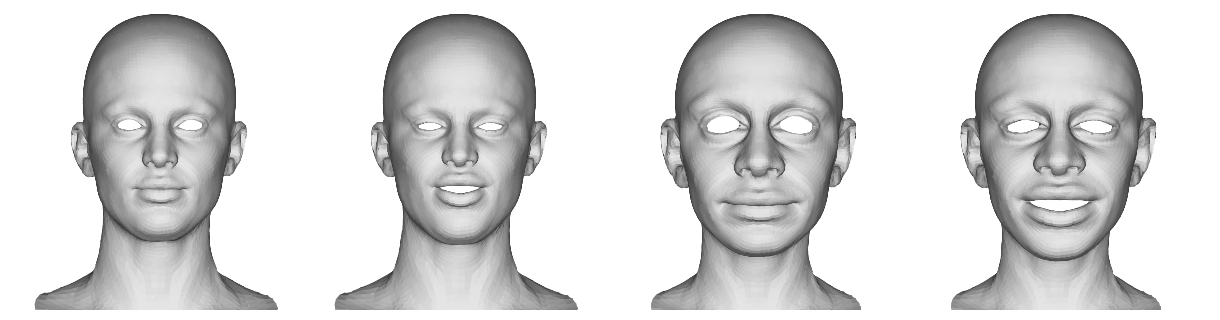

In [5]:
from matplotrender import *
# figure size
SIZE = 3
mesh_scale = 0.7

# mesh that you wanna render src_mesh.v, src_mesh.f
v_list=[ src_mesh.v, src_mesh.motions[FRAME], tgt_mesh.v, V_transferred]
v_list=[ v*mesh_scale for v in v_list]
f_list=[ src_mesh.f ]*len(v_list)

# xyz Euler angle to rotate the mesh
rot_list=[ [0,0,0] ]*len(v_list)

# plot_mesh_image(v_list, f_list, rot_list=rot_list, size=SIZE)
# plot_mesh_image(v_list, f_list, rot_list=rot_list, size=SIZE, mode='normal')
plot_mesh_image(v_list, f_list, rot_list=rot_list, size=SIZE, mode='shade')

(11248,) 1.0 0.0
(11248,) 1.0 0.0
(11248,) 0.0 0.0
(11248,) 0.0 0.0


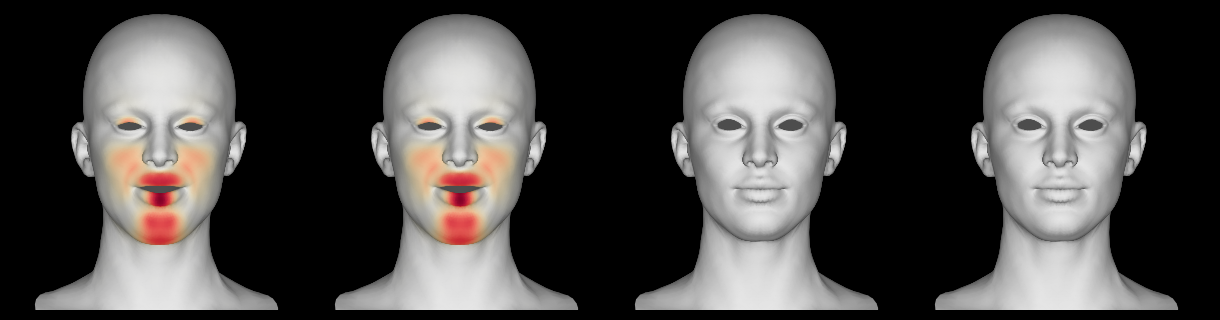

In [ ]:
v_list1=[ 
        src_mesh.motions[FRAME],
        src_mesh.v,
    ]
diff_list1=[
        src_mesh.motions[FRAME]-src_mesh.v, 
    ]
f_list1=[ 
        src_mesh.f,
    ]
plot_mesh_gouraud(v_list1, f_list, 
                     is_diff=True, diff_base=src_mesh.v, diff_revert=False,
                     mesh_scale=mesh_scale,
                     rot_list=rot_list, size=SIZE, mode='shade')

v_list2=[
    V_transferred,
    ]
diff_list2=[
    V_transferred - tgt_mesh.v
    ]
f_list1=[ 
        tgt_mesh.f,
    ]
plot_mesh_gouraud(v_list2, f_list, 
                     diff_list2, is_diff=True, diff_base=tgt_mesh.v, diff_revert=False,
                     mesh_scale=mesh_scale,
                     rot_list=rot_list, size=SIZE, mode='shade')

# Deformation Transfer using igl library
But more like delta mush..?

In [2]:
import igl
import numpy as np
import scipy.sparse as sp
from scipy.sparse.linalg import lsqr
from scipy.sparse.linalg import splu
from easydict import EasyDict

tgt_mesh = EasyDict()
src_mesh = EasyDict()

print('loading meshes')
src_mesh.v, src_mesh.f = igl.read_triangle_mesh("_tmp/m02_model.obj")
print('\t src vertices:', src_mesh.v.shape, '\t faces:',src_mesh.f.shape) # (11248, 3) (22288, 3)

src_mesh.motions = np.load(r'_tmp\040.npy')
print('\t src vertices (posed):', src_mesh.motions.shape) # (219, 11248, 3)

newV, newF = igl.read_triangle_mesh("_tmp/m02_deformed-0.2.obj")
# newV, newF = igl.read_triangle_mesh("../002_mesh.obj")
newV = rescale(newV, src_mesh.v)

tgt_mesh.v = newV
tgt_mesh.f = newF
print('\t tgt vertices:', tgt_mesh.v.shape) # (219, 11248, 3)

loading meshes
	 src vertices: (11248, 3) 	 faces: (22288, 3)
	 src vertices (posed): (219, 11248, 3)
	 tgt vertices: (11248, 3)


Laplacian operator can be expressed as
$$

In [3]:
import numpy as np
import scipy.sparse.linalg as spla
from scipy.sparse import csr_array, csr_matrix
from scipy.sparse import diags, vstack, hstack

FRAME=150

S_G = igl.grad(src_mesh.v, src_mesh.f) # sparse matrix
L_S = S_G.T @ S_G                      # Approx. Laplacian

T_G = igl.grad(tgt_mesh.v, tgt_mesh.f) # sparse matrix
L_T = T_G.T @ T_G                      # Approx. Laplacian

# solve displacement!
b = L_S @ (src_mesh.motions[FRAME] - src_mesh.v)
A = L_T

x = spla.spsolve(A, b)

In [13]:
def get_centroids(x):
    L = x.shape[0]
    return x.sum(0) / (L+1)

In [42]:
x.mean(0)

array([0.00161709, 0.04130753, 0.00757139])

In [14]:
get_centroids(x)

array([0.00161695, 0.04130386, 0.00757072])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


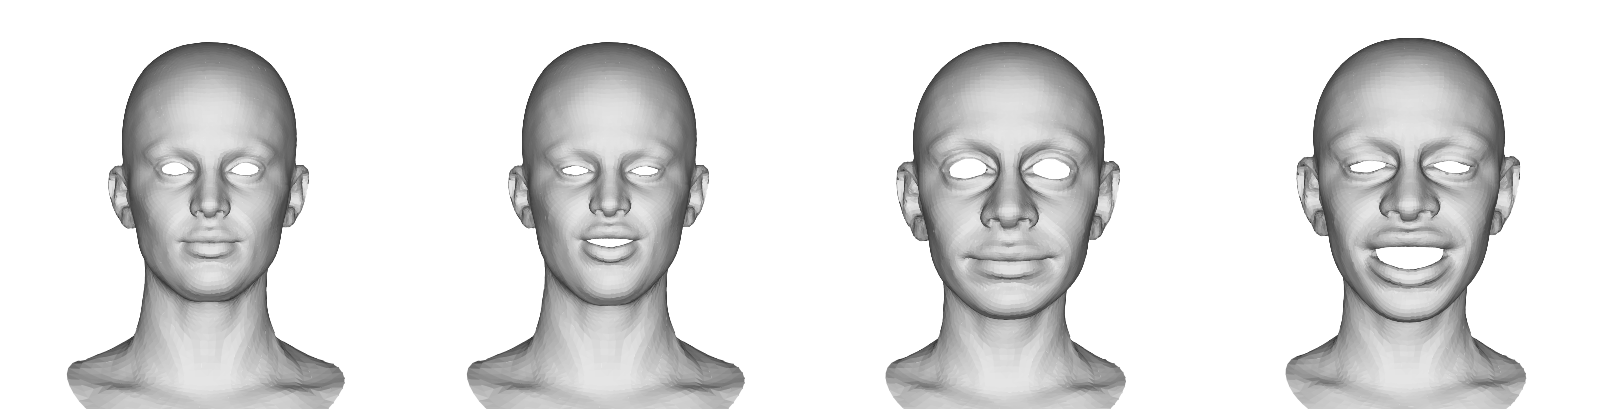

In [34]:
%load_ext autoreload
%autoreload 2
from matplotrender import *
# figure size
SIZE = 4
mesh_scale = 0.6
# mesh_scale=1

# mesh that you wanna render
v_list=[ 
        src_mesh.v, 
        src_mesh.motions[FRAME], 
        tgt_mesh.v, 
        x + tgt_mesh.v, 
        # x_new,
        # x_bc, 
        # x_bc_new
    ]
v_list=[ v*mesh_scale for v in v_list]
f_list=[ 
        src_mesh.f,
        src_mesh.f,
        tgt_mesh.f,
        tgt_mesh.f,
    ]

# xyz Euler angle to rotate the mesh
rot_list=[ [0,0,0] ]*len(v_list)

# plot_mesh_image(v_list, f_list, rot_list=rot_list, size=SIZE)
# plot_mesh_image(v_list, f_list, rot_list=rot_list, size=SIZE, mode='normal')
plot_mesh_image(v_list, f_list, rot_list=rot_list, size=SIZE, mode='shade')

(11248,) 0.04440434231665857 3.2272350549557542e-09
(11248,) 1.0 0.0


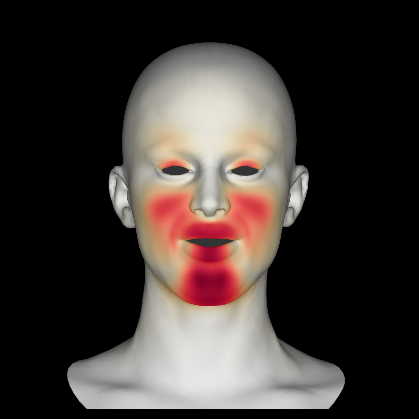

(11248,) 0.12307528615263995 0.0007814115155675175
(11248,) 1.0 0.0


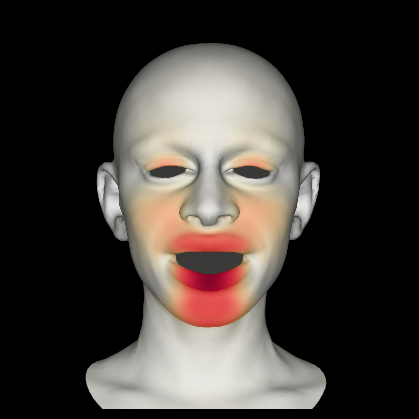

In [37]:

v_list1=[ 
        src_mesh.motions[FRAME],
    ]
diff_list1=[
        src_mesh.motions[FRAME]-src_mesh.v, 
    ]
v_list1=[ v*mesh_scale for v in v_list1]
f_list1=[ 
        src_mesh.f,
    ]
plot_image_array_grd(v_list1, f_list, 
                     diff_list1, is_diff=True, diff_base=src_mesh.v,
                     rot_list=rot_list, size=SIZE, mode='shade')

v_list2=[
    # x + tgt_mesh.v
    (x-x.mean(0,keepdims=True)) + tgt_mesh.v,
    ]
diff_list2=[
    # x
    (x-x.mean(0,keepdims=True)),
    ]
v_list2=[ v*mesh_scale for v in v_list2]
f_list1=[ 
        tgt_mesh.f,
    ]
plot_image_array_grd(v_list2, f_list, 
                     diff_list2, is_diff=True, diff_base=tgt_mesh.v,
                     rot_list=rot_list, size=SIZE, mode='shade')

In [53]:
L_S

tensor(indices=tensor([[    0,     1,     2,  ...,  9679, 11043, 11247],
                       [    0,     1,     2,  ..., 11043, 11156, 11247]]),
       values=tensor([-1.0000, -1.0000, -1.0000,  ...,  0.0833,  0.0833,
                      -1.0000]),
       size=(11248, 11248), nnz=144976, layout=torch.sparse_coo)

In [51]:
L_S.coalesce()

tensor(indices=tensor([[    0,     0,     0,  ..., 11247, 11247, 11247],
                       [    0,     2,   171,  ..., 11239, 11246, 11247]]),
       values=tensor([-1.0000,  0.1667,  0.1667,  ...,  0.5000,  0.2500,
                      -1.0000]),
       size=(11248, 11248), nnz=78324, layout=torch.sparse_coo)

In [38]:
print(S_G)

  (415, 0)	57.88253904082016
  (2533, 0)	8.867121581495
  (6126, 0)	-59.046580155311176
  (11559, 0)	-7.721789893164439
  (13677, 0)	-58.21530879360827
  (16752, 0)	55.8769565664605
  (22703, 0)	-1.2658291731230547
  (24821, 0)	-57.036221116858904
  (28414, 0)	46.95048223036222
  (33847, 0)	-57.34852685029324
  (35965, 0)	-2.903993175503608
  (39040, 0)	47.03884828396855
  (44991, 0)	8.604447493639912
  (47109, 0)	15.729138329462055
  (50702, 0)	16.702876212056793
  (56135, 0)	14.826422053889791
  (58253, 0)	3.86029072684607
  (61328, 0)	20.335710727423205
  (2479, 1)	-87.77968016970478
  (4361, 1)	-85.46021798647645
  (11505, 1)	86.572520134433
  (15506, 1)	95.6490158623694
  (24767, 1)	-62.274398788208956
  (26649, 1)	21.913566447542635
  (33793, 1)	-53.216942397543164
  :	:
  (22274, 11245)	1.5931882898125063
  (33418, 11245)	-2.088281005953583
  (33419, 11245)	-3.7144426725808337
  (44562, 11245)	-5.341222700081844
  (55706, 11245)	-5.036607654840957
  (55707, 11245)	-3.61461085735

In [44]:
x = lsqr(L_T.numpy(), C[:,0].numpy())
# y = lsqr(L_T, C[:,0])[0]
# z = lsqr(L_T, C[:,0])[0]
# x = x.reshape(-1, 3)
# print(x.min(0), x.max(0))


# lu = lu_factor_ata(L_T)
# Atb = A.T @ S.reshape(-1)
# x = lu.solve(Atb)

TypeError: can't convert Sparse layout tensor to numpy.convert the tensor to a strided layout first.

In [30]:
def compute_face_gradient(V, F, f):
    grads = np.zeros((F.shape[0], 3))
    for i, face in enumerate(F):
        v0, v1, v2 = V[face]
        f0, f1, f2 = f[face]

        e1 = v1 - v0
        e2 = v2 - v0

        normal = np.cross(e1, e2)
        area = 0.5 * np.linalg.norm(normal)
        normal /= (2 * area + 1e-8)

        g = ((f1 - f0) * np.cross(normal, v2 - v0) +
             (f2 - f0) * np.cross(v0 - v1, normal)) / (2 * area + 1e-8)

        grads[i] = g

    return grads


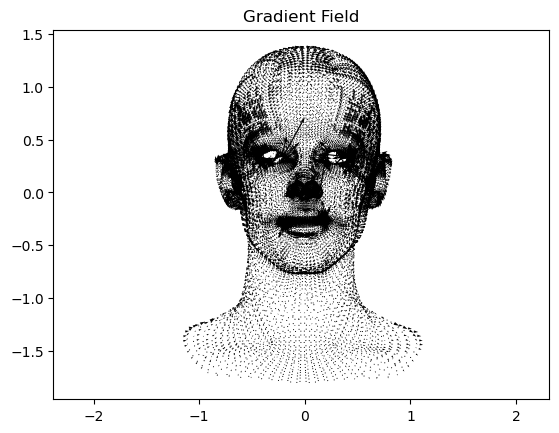

In [34]:
import trimesh
import matplotlib.pyplot as plt

# 임의 메쉬 및 스칼라 함수
# mesh = trimesh.creation.icosphere()


vertices, faces = igl.read_triangle_mesh("_tmp/m02_model.obj")

mesh = trimesh.Trimesh(vertices=vertices,faces=faces)
V, F = mesh.vertices, mesh.faces
f = V[:, 2]  # z값을 스칼라 함수로 사용

grads = compute_face_gradient(V, F, f)

# 각 삼각형의 중심 계산
centroids = V[F].mean(axis=1)

# 시각화 (matplotlib)
# mesh.show()  # 3D 뷰

# 또는 2D quiver plot
plt.quiver(centroids[:,0], centroids[:,1], grads[:,0], grads[:,1])
plt.axis('equal')
plt.title('Gradient Field')
plt.show()


In [35]:
grads.shape

(22288, 3)